In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline
#from PIL import Image # NOT SURE IF WE'RE USING THIS ONE

# NOT SURE WHAT THE POINT OF THE CODE BELOW IS

#if torch.cuda.is_available():
#    torch.backends.cuda.deterministic = True

## Load and Prepare Data

In [92]:
# get data matrices and labels
train_data = np.load('../process/project_data/x_train_v1.npy')
read_train_labels = pd.read_csv('../process/project_data/y_train_v1.csv')
train_labels = read_train_labels['Label'] == 'Anomaly'
train_labels = train_labels.astype(int)
test_data = np.load('../process/project_data/x_test_v1.npy')
read_test_labels = pd.read_csv('../process/project_data/y_test_v1.csv')
test_labels = read_test_labels['Label'] == 'Anomaly'
test_labels = test_labels.astype(int)

data_dims = (19, 48)

In [93]:
train_data = train_data[0:1000]
test_data = test_data[0:1000]
train_labels = train_labels[0:1000]
test_labels = test_labels[0:1000]

In [6]:
train_data.shape

(1000, 19, 48)

In [15]:
train_data[0].shape

(19, 48)

In [10]:
train_labels.shape

(1000,)

In [11]:
train_labels[1]

0

In [126]:
class logDataset(Dataset):
    """Log Anomaly Features Dataset"""
    
    def __init__(self, data_vec, dims, labels=None):
        self.X = data_vec
        self.dims = dims
        self.y = labels
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        data_matrix = self.X[idx]
        
        if not self.y is None:
            return(data_matrix, self.y[idx])
        else:
            return data_matrix


In [30]:
# NOTE THAT AS WE'VE DONE TF-IDF, WE MAY NOT WANT TO NORMALIZE
# HOWEVER, ONE OF THE ODD THINGS HERE IS THAT SINCE WE'RE PASSING FILTERS OVER THINGS
# IF THE COLUMNS REPRESENT SLIGHTLY DIFFERENT THINGS IT MAY BE AN ISSUE, ESPECIALLY FOR POOLING?
# NORMALLY EACH PIXEL REPRESENTS THE EXACT SAME THING, NOT SURE IF THAT'S STILL THE CASE AFTER
# TF-IDF

# define transforms
#train_mean = (0.5, 0.5, 0.5)
#train_std = (0.5, 0.5, 0.5)

#apply_transforms = transforms.Compose([#transforms.Resize((32, 32)), # probably not using this
#                                        transforms.ToPILImage(), # believe this is required
#                                        transforms.ToTensor(),
#                                        #transforms.Normalize(train_mean, train_std),
#                                        transforms.Pad((0, 0, 0, 1))]) # not sure if this is quite correct


In [95]:
train_data = torch.tensor(train_data, dtype=torch.float32)
train_data = F.pad(input=train_data, pad=(0, 0, 0, 1), mode='constant', value=0)
train_data = np.expand_dims(train_data, axis=1)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_data = F.pad(input=test_data, pad=(0, 0, 0, 1), mode='constant', value=0)
test_data = np.expand_dims(test_data, axis=1)

In [96]:
# Hyperparameters
RANDOM_SEED = 1
# THESE ARE ALL STARTING POINTS BASED ON LAB3
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = data_dims[0] * data_dims[1]
# not sure we should be using an architecture with 2 classes with softmax
# doesn't it make more sense to have a single output node
# previous labs/lectures have 2 classes with softmax which is somewhat confusing
NUM_CLASSES = 2

# Other
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"


In [ ]:
# THERE'S AN ISSUE WITH TRYING TO PASS THE DATAFORMAT WITH FLOATS INTO THE TORCHVISION TRANSFORMS AS IT"S
# EXPECTING IMAGE TYPE DATA (SEE WARNINGS BELOW)
# EITHER NEED TO FIGURE OUT HOW WE CAN COERCE IT INTO AN IMAGE OR USE A DIFFERENT STYLE OF TRANSFORMS THAT STILL ALLOWS
# PADDING ETC

In [127]:
train_dataset = logDataset(train_data, dims = data_dims, labels = train_labels)
test_dataset = logDataset(test_data, dims = data_dims, labels = test_labels)

In [122]:
train_dataset.__getitem__(3)

(array([[[ 0.        ,  0.        , -1.9271919 ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        , -1.2126474 ,
           0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        , -0.        ,
          -0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,
          -0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,
           0.        , -0.        , -0.        ,  0.        ,
          -0.        ,  0.        , -0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        , -2.0877912 ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        , -1.0913827 ,
           0.        ,  0.        ,  0.        ,  0.        ,
       

In [128]:
# use DataLoader
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=0, # couldn't use workers https://github.com/fastai/fastbook/issues/85
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=0,
                         shuffle=False)

# Checking the dataset
for data, labels in train_loader:  
    print('Matrix batch dimensions:', data.shape)
    print('Matrix label dimensions:', labels.shape)
    break

# Checking the dataset
for data, labels in test_loader:  
    print('Matrix batch dimensions:', data.shape)
    print('Matrix label dimensions:', labels.shape)
    break

Matrix batch dimensions: torch.Size([128, 1, 20, 48])
Matrix label dimensions: torch.Size([128])
Matrix batch dimensions: torch.Size([128, 1, 20, 48])
Matrix label dimensions: torch.Size([128])


## Setup Model

In [129]:
# this is something to do with warming up the nn
# NEED TO FIGURE THIS OUT AND KEEP OR REMOVE
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [130]:
##########################
### MODEL
##########################


class logCNN(nn.Module):

    def __init__(self, num_classes):
        super(logCNN, self).__init__()
        # noticed that in many of the example models we're initializing weights and biases but
        # not in the CNN example, check into this
        self.num_classes = num_classes
        self.features = nn.Sequential(
            
            # Selection of 16 and 32 based on discussion with Debangsha, use for now
            # will need to figure out kernel size that works for dims and potentially add pooling
            # need to figure out how to deal with non-square image
            nn.Conv2d(1, 16, kernel_size=2),
            nn.ReLU(),
            #F.pad(pad=(0, 1, 0, 1), mode='constant', value=0),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=2),
            nn.ReLU(),
            #F.pad(pad=(0, 1, 0, 1), mode='constant', value=0),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            # NEED TO FIGURE OUT THE SIZE OF THE IMAGE FOR THE *4*4 part
            nn.Linear(1408, 120), # NEED TO DECIDE ON NUMBER OF NODES (120 BASED ON LAB3)
            nn.ReLU(),
            nn.Linear(120, 84), # NEED TO DECIDE ON NUMBER OF NODES (84 BASED ON LAB3)
            nn.ReLU(),
            nn.Linear(84, num_classes), # NOT SURE WE WANT TO BE USING 2 NODE OUTPUT
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        print(x.shape)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1) # NOT SURE WE NEED SOFTMAX, POTENTIALLY SIGMOID?
        return logits, probas


## NOTE: WE MAY WANT TO CONSIDER USING DROPOUT AND L2 PENALTY; SEE LETURE 4 EXAMPLES FOR THIS
## RELATIVELY EASY TO IMPLEMENT BUT MAY WANT TO CONSIDER ADDING VALIDATION SET SPLIT FROM THE TRAINING SET
## WHEN DOING THIS AND PLOTTING THE VALIDATION/TRAINING COST FUNCTIONS

In [131]:
torch.manual_seed(RANDOM_SEED)

model = logCNN(NUM_CLASSES) # THIS WILL BE UPDATED IF NOT USING 2 OUTPUT NODES
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train Model

In [137]:
# NEED TO FIGURE OUT THE BEST FUNCTION FOR ACCURACY
# NEED TO FOCUS ON TRUE/FALSE
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE, dtype=torch.long)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
minibatch_cost = [] # this isn't in the CNN model example but is from lecture 3 example files
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE, dtype=torch.long)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets) # NEED TO MODIFY BASED ON BEST COST FUNCTION
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost) # from lecture 3 example files
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING - MAY WANT TO MODIFY LOGGING INTERVALS
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        
    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        cost = compute_accuracy(model, train_loader, device=DEVICE)
        epoch_cost.append(cost) # from lecture 3 example files
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, cost))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

torch.Size([128, 1408])
Epoch: 001/010 | Batch 0000/0008 | Cost: 0.0865
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([104, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([104, 1408])
Epoch: 001/010 | Train: 97.900%
Time elapsed: 0.00 min
torch.Size([128, 1408])
Epoch: 002/010 | Batch 0000/0008 | Cost: 0.2321
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([104, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([104, 1408])
Epoch: 002/010 | Train: 97.900%
Time elapsed: 0.00 min
torch.Size([128, 1408])
Ep

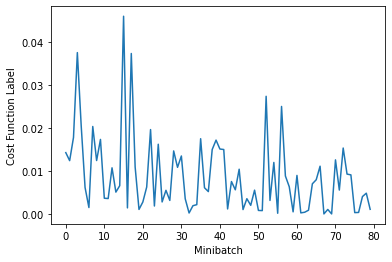

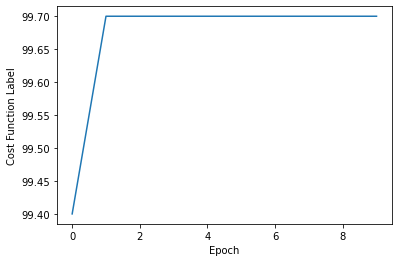

In [142]:
# plot cost functions
minibatch_cost_cpu = [i.cpu().detach().numpy() for i in minibatch_cost]
epoch_cost_cpu = [i.cpu().detach().numpy() for i in epoch_cost]

plt.plot(range(len(minibatch_cost_cpu)), minibatch_cost_cpu)
plt.ylabel('Cost Function Label') # update this label after cost function selected
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost_cpu)), epoch_cost_cpu)
plt.ylabel('Cost Function Label') # update this label after cost function selected
plt.xlabel('Epoch')
plt.show()

## Evaluation

In [143]:
with torch.set_grad_enabled(False): # save memory during inference
    # THIS NEEDS TO BE UPDATED BASED ON THE FUNCTION NAME WE'RE USING
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([128, 1408])
torch.Size([104, 1408])
Test accuracy: 99.20%


In [1]:
# WE NEED TO BE EXTENDING THE PERFORMANCE MEASURES TO INCLUDE THOSE USED IN THE PAPERS
# F SCORE, PRECISION ETC ETC, MOST OF THE PAPERS SEEM TO USE SIMILAR METRICS, SHOULD BE RELATIVELY SIMPLE
# AND COULD BE POTENTIALLY BUILD DIRECTLY INTO THE COST FUNCTION (THE FUNCTION COULD RETURN MULTIPLE PARAMS AND WE WOULD OBVIOUSLY JUST USE THE ONE WE NEEDED FOR MODEL TRAINING BUT THEN WE WOULD HAVE ACCESS TO ALL OF THEM INSTEAD OF WRITING ANOTHER FUNCTION)

In [2]:
# ALSO RECOMMEND SOME SORT OF VIS TOOL ON BEING ABLE TO LOOK AT A COUPLE OF THE TIME IMAGES THAT ARE LABELLED ANOMALOUS CORRECTLY AND ONES THAT ARE LABELLED ANOMLAOUS INCORRECTLY OR NORMAL INCORRECTLY

# MAY REQURIE PASSING THE THE TIME IMAGE TO PIL (IF THIS DIDN"T NEED TO BE ALREADY DONE ABOVE)